# Dynamically Expandable Network

Notebook brouillon

## Imports

In [47]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import logging as log
import re
import random
import collections
import time

import matplotlib.pyplot as plt
import numpy as np


## Chargement des datasets

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [40]:
# Conversion sortie torchvision en tenseur normalisé
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Affichage image dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
class Data(object):

In [20]:
cifar10_train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

cifar10_test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [35]:
mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

mnist_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

lsun_train_set = torchvision.datasets.PhotoTour(root='./data', train=True,
                                        download=True, transform=transform)
lsun_train_loader = torch.utils.data.DataLoader(stl10_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

lsun_test_set = torchvision.datasets.PhotoTour(root='./data', train=False,
                                       download=True, transform=transform)
lsun_test_loader = torch.utils.data.DataLoader(stl10_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

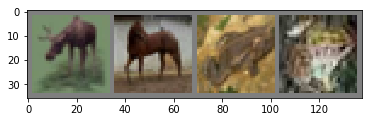

 deer horse  frog  frog


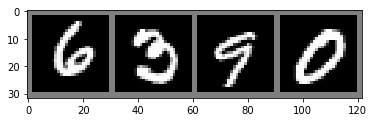

    6     3     9     0


In [36]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# get some random training images
dataiter = iter(mnist_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print(' '.join('%5s' % mnist_classes[labels[j]] for j in range(4)))

In [60]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images[0].shape

torch.Size([3, 32, 32])

## Création des modèles baseline

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [9]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ConvolutionalNet()

# modèle 2

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(400, 312)
        self.fc2 = nn.Linear(312, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = SimpleNet()

In [89]:
simple_net = nn.Sequential(nn.Linear(784, 312),
                    nn.ReLU(),
                    nn.Linear(312, 128),
                    nn.ReLU(),
                    nn.Linear(128, 10))

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500


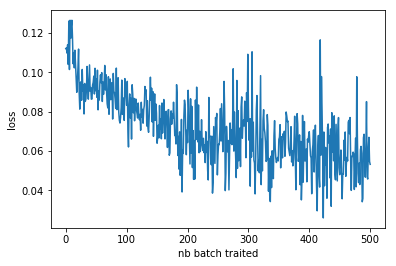

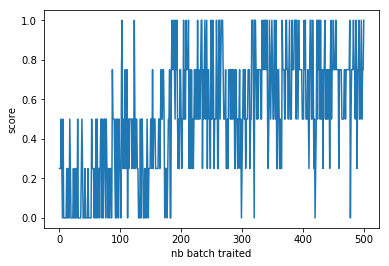

In [90]:
ml = nn.MSELoss()
ite = 500
opt = optim.SGD(simple_net.parameters(), lr=1e-3)

lossHisto = []
scoreHisto = []

for i,(x,yN) in enumerate(mnist_train_loader):
    if i > ite :
        break
    if i%(ite/10) == 0:
        print("Iteration", i)
    
    x = Variable(x.view(-1,784))
        
    y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
    y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
    y = Variable(y_onehot)
    
    f = simple_net.forward(x)
    loss = ml.forward(f, y)
    loss.backward()
    opt.step()
    
    lossHisto.append(loss.data.mean())
    ypred = torch.max(f, 1)[1]
    scoreHisto.append(torch.eq(ypred.data, yN).float().mean())
    
plt.plot(lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

In [103]:
for module in simple_net.modules():
    print(module, list(module.named_parameters()))
    for param in module.parameters():
        print(type(param.data), param.size())

Sequential (
  (0): Linear (784 -> 312)
  (1): ReLU ()
  (2): Linear (312 -> 128)
  (3): ReLU ()
  (4): Linear (128 -> 10)
) [('0.weight', Parameter containing:
-2.2518e-02  1.0130e-03 -2.0529e-02  ...  -2.1948e-02  3.0352e-02  3.7597e-02
 3.9459e-03 -4.2863e-03 -2.6001e-03  ...   1.2906e-03 -2.3198e-02 -4.5150e-03
-1.8233e-02  7.4940e-03  6.9910e-04  ...   3.3920e-02  2.1186e-02  3.8868e-02
                ...                   ⋱                   ...                
 1.8000e-02 -1.5157e-02  1.4782e-02  ...  -2.5375e-02  2.8452e-02  2.5041e-02
 1.4528e-02  3.2923e-02  2.9549e-02  ...   2.7296e-02 -7.1165e-03 -1.4458e-02
 4.5566e-04  6.2602e-03 -2.5020e-02  ...   1.7383e-02  2.6691e-02 -4.9468e-03
[torch.FloatTensor of size 312x784]
), ('0.bias', Parameter containing:
1.00000e-02 *
 -2.4853
 -1.8642
 -3.7546
  2.5748
  0.6508
 -2.1385
 -1.5194
  0.2042
  3.2860
  2.5334
  3.6666
  0.3149
 -0.5474
 -2.5285
  1.4100
 -2.9411
  3.2856
 -1.8755
  2.6836
 -2.0959
 -2.6519
 -2.7708
  3.4572


## Modèle DEN

Basé sur les explications et algorithmes proposés par l'article

In [71]:
class DEN(nn.Module):
    def __init__(self):
        pass
    
    def forward(self, x):
        pass

## Expérimentations

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [77]:
losses = []

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    saving_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        saving_loss += loss.data[0]
        if i % 200 == 199:    # save every 200 mini-batches
            losses.append(saving_loss / 200)
            saving_loss = 0.0
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

plt.plot(losses)
plt.show()

RuntimeError: invalid argument 3: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1 at /opt/conda/conda-bld/pytorch_1503965122592/work/torch/lib/THNN/generic/SpatialClassNLLCriterion.c:40

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [55]:
outputs = net(Variable(images))

RuntimeError: size mismatch, m1: [112 x 28], m2: [400 x 312] at /opt/conda/conda-bld/pytorch_1503965122592/work/torch/lib/TH/generic/THTensorMath.c:1293

In [14]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [15]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 64 %
Accuracy of  bird : 29 %
Accuracy of   cat : 52 %
Accuracy of  deer : 44 %
Accuracy of   dog : 53 %
Accuracy of  frog : 49 %
Accuracy of horse : 59 %
Accuracy of  ship : 71 %
Accuracy of truck : 67 %


In [17]:
net.cuda()

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [ ]:
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())